<a href="https://colab.research.google.com/github/dwahast/Deep-learning/blob/master/MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons
- Link útil (https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c)

In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F # softmax

#import pandas as pd # organize files 


In [2]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 170270720/170498071 [00:24<00:00, 10520600.97it/s]

Files already downloaded and verified


In [3]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, shuffle=False)
print(len(test_loader))

10000


In [0]:
# Definir a arquitetura MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
        self.activation_function = nn.Sigmoid()
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x
# Arquitecture with RELU      
class MLP_relu(nn.Module):
    def __init__(self):
        super(MLP_relu, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x),dim =1)
        return x
      
# New Arquitecture with RELU   
class MLP_Srelu(nn.Module):
    def __init__(self):
        super(MLP_Srelu, self).__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim =1)
        return x   


In [5]:
model = MLP_Srelu()
print(model)

MLP_Srelu(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


In [0]:
# Definir otimizador e loss
# Nota: testar outros otimizadores e funções de loss (em particular cross entropy)

def optimizer_set(optimizer_method, learning_rate):
  if optimizer_method == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.5)
  elif optimizer_method == "adadelta":
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adamax":
    optimizer = torch.optim.Adamax(model.parameters(), lr = learning_rate)
  elif optimizer_method == "rms":
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
  return optimizer

def loss_function_set(loss_function):
  if loss_function == "mse":
    loss_fn = torch.nn.MSELoss()
  elif loss_function == "nllos":
     loss_fn = torch.nn.NLLoss()
  elif loss_function == "cross":
     loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn
  

In [0]:
def one_hot(label, output_size):
    
    label_select = np.zeros(output_size)
    label_select[label]=1
    
    return torch.Tensor(label_select)

In [0]:
def evaluate(weights, loss_function, dataset):
  model.eval() # set model to Evaluate "mode"
 # losses = []
  corrects = 0
  current_total = 0
  accuracies = 0
  
 # loss_fn = loss_function_set(loss_function)
  
  for image, label in dataset:
    weights = model(image)
    
   # if(loss_function == 'mse'):
   #   label_target = one_hot(label,10) # one_hot to set the training class in the escalar
   #   loss = loss_fn(weights,label_target)
   # else:
   #   loss = loss_fn(weights,label)
      
   # losses.append(loss.item())
    
    _, predicted = torch.max(weights.data, 1)
    
    if(predicted==label):
      corrects += 1
    
    current_total += 1
  
  accuracy = corrects/current_total
 
  #print("Mean Accuracy: ", np.mean(accuracies))
  return accuracy #, np.mean(losses)
      

In [0]:
# Realizar o treinamento aqui
def fit(epochs, optimizer_method, loss_function, learning_rate):
  
  print("Opt Method:", optimizer_method.upper(), "| Loss Function:", loss_function.upper(), "| Learning Rate:", learning_rate)
  optimizer = optimizer_set(optimizer_method, learning_rate) #optimizer and Learning rate setter
  loss_fn = loss_function_set(loss_function) 
  accuracies = []
  losses = []
  train_acc = []
  for epoch in range(epochs):
    model.train() # Set model to TRAIN "mode" (can be set to False for Test)
    epoch_losses = []
    for image,label in train_loader:
      optimizer.zero_grad()  # cleaning gradients between mini batches
      weights = model(image) 
     
      if(loss_function == 'mse'):
        label_target = one_hot(label,10) # one_hot to set the training class in the escalar
        loss = loss_fn(weights,label_target)
      else: 
        loss = loss_fn(weights, label)
        
      loss.backward() # Backpropagation 
      optimizer.step() # Optimization Method
      
      epoch_losses.append(loss.item())

    losses.append(np.mean(epoch_losses)) # Append mean losses for each epoch
   
    
    acc = evaluate(model, loss_function, train_loader)
    train_acc.append(acc)
    acc = evaluate(model, loss_function,test_loader) #evaluate
    accuracies.append(acc)
    
    
    
   # train_losses.append(train_lss)
    #if(epoch%10==0):
    print("Epoch:",epoch, "- Average loss:", np.mean(epoch_losses),"- Accuracy:", acc) # Print mean Loss for each epoch
    
  
  #print("Mean Accuracies:",np.mean(Accuracies))
  #plt.title("Accuracies")
  #plt.plot(Accuracies)
  #plt.show()
  #plt.title("Test Loss")
  #plt.plot(Test_losses)
  #plt.show()
 
  return {
      "Model": weights,
      "Acc": accuracies,
      "Train Acc": train_acc,
      "Loss": losses,
      "Name": optimizer_method + " | " + loss_function + " | " + str(learning_rate)
      #"Evaluate Train Loss": train_losses,
      
  }

In [13]:
# Avaliar o modelo aqui (no conjunto de teste)
trained_models = fit(15,"sgd", "mse", 0.01)

Opt Method: SGD | Loss Function: MSE | Learning Rate: 0.01
Epoch: 0 - Average loss: 5.8559482095909114 - Accuracy: 0.4374
Epoch: 1 - Average loss: 5.855809612989425 - Accuracy: 0.4334
Epoch: 2 - Average loss: 5.855633810815811 - Accuracy: 0.4358
Epoch: 3 - Average loss: 5.855490061702728 - Accuracy: 0.4312
Epoch: 4 - Average loss: 5.855323042106629 - Accuracy: 0.4171
Epoch: 5 - Average loss: 5.855222151346207 - Accuracy: 0.4378
Epoch: 6 - Average loss: 5.855092734928131 - Accuracy: 0.4294
Epoch: 7 - Average loss: 5.854946582393646 - Accuracy: 0.4296
Epoch: 8 - Average loss: 5.854806279411316 - Accuracy: 0.4417
Epoch: 9 - Average loss: 5.854663857269287 - Accuracy: 0.4374
Epoch: 10 - Average loss: 5.8545323713302615 - Accuracy: 0.4426
Epoch: 11 - Average loss: 5.854439114685059 - Accuracy: 0.4332
Epoch: 12 - Average loss: 5.854288536548615 - Accuracy: 0.4493
Epoch: 13 - Average loss: 5.854138204755783 - Accuracy: 0.4378
Epoch: 14 - Average loss: 5.854009735403061 - Accuracy: 0.4364


In [14]:
trained_models1 = fit(15,"adadelta",   "mse", 0.01)

Opt Method: ADADELTA | Loss Function: MSE | Learning Rate: 0.01
Epoch: 0 - Average loss: 5.852820529403687 - Accuracy: 0.4627
Epoch: 1 - Average loss: 5.852866496801377 - Accuracy: 0.4543
Epoch: 2 - Average loss: 5.852949303646088 - Accuracy: 0.4491
Epoch: 3 - Average loss: 5.853016612806321 - Accuracy: 0.4542
Epoch: 4 - Average loss: 5.853081931772232 - Accuracy: 0.4505
Epoch: 5 - Average loss: 5.853129442424774 - Accuracy: 0.4555
Epoch: 6 - Average loss: 5.853182995700836 - Accuracy: 0.448
Epoch: 7 - Average loss: 5.853188731908798 - Accuracy: 0.4587
Epoch: 8 - Average loss: 5.85325564745903 - Accuracy: 0.4508
Epoch: 9 - Average loss: 5.8532733754539485 - Accuracy: 0.4394
Epoch: 10 - Average loss: 5.853269709815979 - Accuracy: 0.4455
Epoch: 11 - Average loss: 5.853295192623138 - Accuracy: 0.4467
Epoch: 12 - Average loss: 5.8533240901756285 - Accuracy: 0.4358
Epoch: 13 - Average loss: 5.853289510402679 - Accuracy: 0.4411
Epoch: 14 - Average loss: 5.85330880311966 - Accuracy: 0.4375


<function matplotlib.pyplot.show>

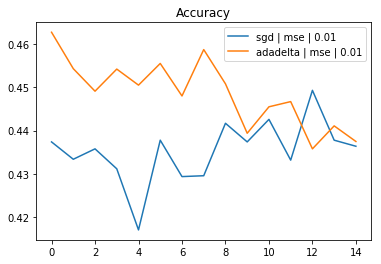

In [15]:
plt.title("Accuracy")
plt.plot(trained_models["Acc"],label=trained_models["Name"])
plt.plot(trained_models1["Acc"],label=trained_models1["Name"])
plt.legend(loc='best')
plt.show